In [21]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [52]:
def plot_scaler(data, col, categories=None , rates=None, c=None, X_scaled=None):
    scaler = StandardScaler()
    print(f'Columns: {[x for x in col if x not in rates]}')
    if categories is None and X_scaled is None:
        X_scaled = scaler.fit_transform(data[col])
    elif X_scaled is None:
        col = [x for x in col if x not in rates]
        X_scaled = scaler.fit_transform(data[col])

    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
    print(f'Cumulative variance ratio for 2 components: {cumulative_variance_ratio[1]*100:.2f}%')
    print(f'component 3: {explained_variance_ratio[2]*100:.2f}%')

    fig, ax = plt.subplots(3, 3, figsize=(16, 12))
    ax[0, 0].bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
    ax[0, 0].set_xlabel('Principal Component')
    ax[0, 0].set_ylabel('Explained Variance Ratio')
    ax[0, 0].set_title('Explained Variance Ratio by Principal Component')
    
    ax[0, 1].plot(range(1, len(pca.explained_variance_ratio_) + 1), cumulative_variance_ratio)
    ax[0, 1].set_xlabel('Number of components')
    ax[0, 1].set_ylabel('Cumulative explained variance')
    ax[0, 1].set_title('Scree Plot')


    feature_names = data[col].columns
    if len(feature_names) > 2:
        for i in range(len(feature_names)):
            ax[1, 0].arrow(0, 0, pca.components_[0, i], pca.components_[1, i], 
                           head_width=0.05, head_length=0.05, color='blue')
    
        for i, feature in enumerate(feature_names):
            ax[1, 0].text(pca.components_[0, i] * 1.15, pca.components_[1, i] * 1.15, feature,
                          color='black', ha='center', va='center')
    
        ax[1, 0].set_xlim(-1, 1)
        ax[1, 0].set_ylim(-1, 1)
        ax[1, 0].set_xlabel('Principal Component 1')
        ax[1, 0].set_ylabel('Principal Component 2')
        ax[1, 0].set_title('Correlation Circle')
        ax[1, 0].grid()
        
        for i in range(len(feature_names)):
            ax[1, 1].arrow(0, 0, pca.components_[0, i], pca.components_[2, i], 
                           head_width=0.05, head_length=0.05, color='blue')
        for i, feature in enumerate(feature_names):
            ax[1, 1].text(pca.components_[0, i] * 1.15, pca.components_[2, i] * 1.15, feature,
                          color='black', ha='center', va='center')
        ax[1, 1].set_xlim(-1, 1)
        ax[1, 1].set_ylim(-1, 1)
        ax[1, 1].set_xlabel('Principal Component 1')
        ax[1, 1].set_ylabel('Principal Component 2')
        ax[1, 1].set_title('Correlation Circle')
        ax[1, 1].grid()
        
        for i in range(len(feature_names)):
            ax[1, 2].arrow(0, 0, pca.components_[0, i], pca.components_[3, i], 
                           head_width=0.05, head_length=0.05, color='blue')
        for i, feature in enumerate(feature_names):
            ax[1, 2].text(pca.components_[0, i] * 1.15, pca.components_[3, i] * 1.15, feature,
                          color='black', ha='center', va='center')
        ax[1, 2].set_xlim(-1, 1)
        ax[1, 2].set_ylim(-1, 1)
        ax[1, 2].set_xlabel('Principal Component 1')
        ax[1, 2].set_ylabel('Principal Component 2')
        ax[1, 2].set_title('Correlation Circle')
        ax[1, 2].grid()

        scatter = ax[2, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=c, alpha=0.5)
        ax[2, 0].set_xlabel('First principal component')
        ax[2, 0].set_ylabel('Second principal component')
        ax[2, 0].set_title('Projection of Individuals')
        cbar = plt.colorbar(scatter, ax=ax[1, 1])
        scatter = ax[2, 1].scatter(X_pca[:, 0], X_pca[:, 2], c=c, alpha=0.5)
        ax[2, 1].set_xlabel('First principal component')
        ax[2, 1].set_ylabel('Third principal component')
        ax[2, 1].set_title('Projection of Individuals')
        cbar = plt.colorbar(scatter, ax=ax[2, 0])
        scatter = ax[2, 2].scatter(X_pca[:, 1], X_pca[:, 2], c=c, alpha=0.5)
        ax[2, 2].set_xlabel('First principal component')
        ax[2, 2].set_ylabel('Forth principal component')
        ax[2, 2].set_title('Projection of Individuals')
        cbar = plt.colorbar(scatter, ax=ax[2, 1])
    plt.tight_layout()
    plt.show()
    return X_scaled , X_pca

In [23]:
def create_boxplot(ax, data, col):
    sns.boxplot(x=data[col], ax=ax)
    ax.set_title(f'Distribution of {col}')

def plot_boxplots(data, columns):
    numCols = len(columns)
    numRows = numCols // 3 + (numCols % 3 > 0)
    
    fig, axes = plt.subplots(numRows, 3, figsize=(15, 5 * numRows))
    axes = np.array(axes).flatten()
    
    list(map(create_boxplot, axes[:numCols], [data]*numCols, columns))
    
    plt.tight_layout()
    plt.show()

In [41]:
def plot_boxplots_per_cluster(X, clusters, features):
    X['cluster'] = clusters
    for feature in features:
        fig, ax = plt.subplots(figsize=(12, 6))
        sns.boxplot(x='cluster', y=feature, data=X, ax=ax)
        ax.set_title(f'Distribution of {feature} per cluster')

In [24]:
def plot_pairplots(data, col):
	sns.set_theme(style="ticks")
	sns.pairplot(data[col], diag_kind="kde", markers="o", plot_kws={'alpha': 0.6})
	plt.tight_layout()
	plt.show()

In [25]:
def plot_scatterplot(data, col, c=None):
    fig, ax = plt.subplots(1, 1, figsize=(16, 6))
    ax.scatter(data[col[0]], data[col[1]], c=c, alpha=0.5)
    ax.set_xlabel(col[0])
    ax.set_ylabel(col[1])
    ax.set_title('Scatter Plot')
    plt.show()

In [26]:
def agglomerative_clustering_n(X_scaled):
    silhouette_list = []
    cluster_sizes_list = []
    best_score = -1
    n_clusters_range = range(3, 15)
    
    for n_clusters in n_clusters_range:
        model = AgglomerativeClustering(n_clusters=n_clusters)
        clusters = model.fit_predict(X_scaled)
        
        silhouette_avg = silhouette_score(X_scaled, clusters)
        silhouette_list.append(silhouette_avg)
        cluster_sizes = np.bincount(clusters)
        cluster_sizes_list.append(cluster_sizes)
        print(f'Nombre de clusters: {cluster_sizes}, Silhouette score: {silhouette_avg:.2f}')

        if silhouette_avg > best_score:
            best_clusters = clusters
            best_model = model
            best_score = silhouette_avg

    return best_clusters, best_model

In [27]:
def kmeans_n(X_scaled):
    silhouette_list = []
    cluster_sizes_list = []
    best_score = -1
    for i in range(3, 15):
        kmeans = KMeans(n_clusters=i, random_state=0)
        clusters = kmeans.fit_predict(X_scaled)
        silhouette_avg = silhouette_score(X_scaled, clusters, n_jobs=-1)
        silhouette_list.append(silhouette_avg)
        cluster_sizes = np.bincount(clusters)  
        print(f'cluster size: {cluster_sizes} Silhouette score: {silhouette_avg:.2f}')
        cluster_sizes_list.append(cluster_sizes)
        if silhouette_avg > best_score:
                best_cluster = clusters
                best_kmeans = kmeans
                best_score = silhouette_avg
    return best_cluster, best_kmeans
        
    

In [28]:
def dbscan_n(X_scaled):
    silhouette_list = []
    cluster_sizes_list = []
    best_score = -1
    eps_values = np.linspace(0.1, 1.1, num=10)
    for eps in eps_values:
        model = DBSCAN(eps=eps, min_samples=200)
        clusters = model.fit_predict(X_scaled)
        if len(set(clusters)) > 1:
            silhouette_avg = silhouette_score(X_scaled, clusters, n_jobs=-1)
            silhouette_list.append(silhouette_avg)
            cluster_sizes = len(set(clusters)) - (1 if -1 in clusters else 0)
            cluster_sizes_list.append(cluster_sizes)
            print(f'cluster size: {cluster_sizes} Silhouette score: {silhouette_avg:.2f}')
        if silhouette_avg > best_score:
                best_clusters = clusters
                best_model = model
                best_score = silhouette_avg
    return best_clusters, best_model
            
    

In [50]:
X_scaled = pd.read_csv('X_scaled.csv', header=None)
df = pd.read_csv('df_grouped.csv')
X = df.iloc[:,1:]
features = X.columns
rates = ['credit_card_rate', 'boleto_rate', 'voucher_rate', 'debit_card_rate']
rfm = ['recency', 'frequency', 'monetary']
profile = ['average_review_score', 'nb_of_different_sellers']

(95420, 8)
(95420, 8)
RangeIndex(start=0, stop=0, step=1)


cluster size: [45477 18964 30979] Silhouette score: 0.33
cluster size: [49840 18970 25133  1477] Silhouette score: 0.38
cluster size: [42110 18950 29836  1476  3048] Silhouette score: 0.38
cluster size: [40157 18308 28915  1472  2986  3582] Silhouette score: 0.44
cluster size: [39066 18147 28520  1468  2975  3468  1776] Silhouette score: 0.46
cluster size: [39068  7046 28572  1468  2975  1709  3467 11115] Silhouette score: 0.43
cluster size: [36405  6975 26339  1464  2972  5528  1546 11051  3140] Silhouette score: 0.45
cluster size: [25827  6950 15513  1466  2968  1664  1544 11071  3094 25323] Silhouette score: 0.38
cluster size: [25840  6952 15508  1466  2968  1664   280 11070  2814 25312  1546] Silhouette score: 0.39
cluster size: [24215  6971 14734  1463  2968   900   280 11059  2772 23500  1530  5028] Silhouette score: 0.41
cluster size: [23617  6982 14482  1462  2967   902   280 11010  2786  2692   403  4934
 22903] Silhouette score: 0.43
cluster size: [23612  6815 14495  1462  29

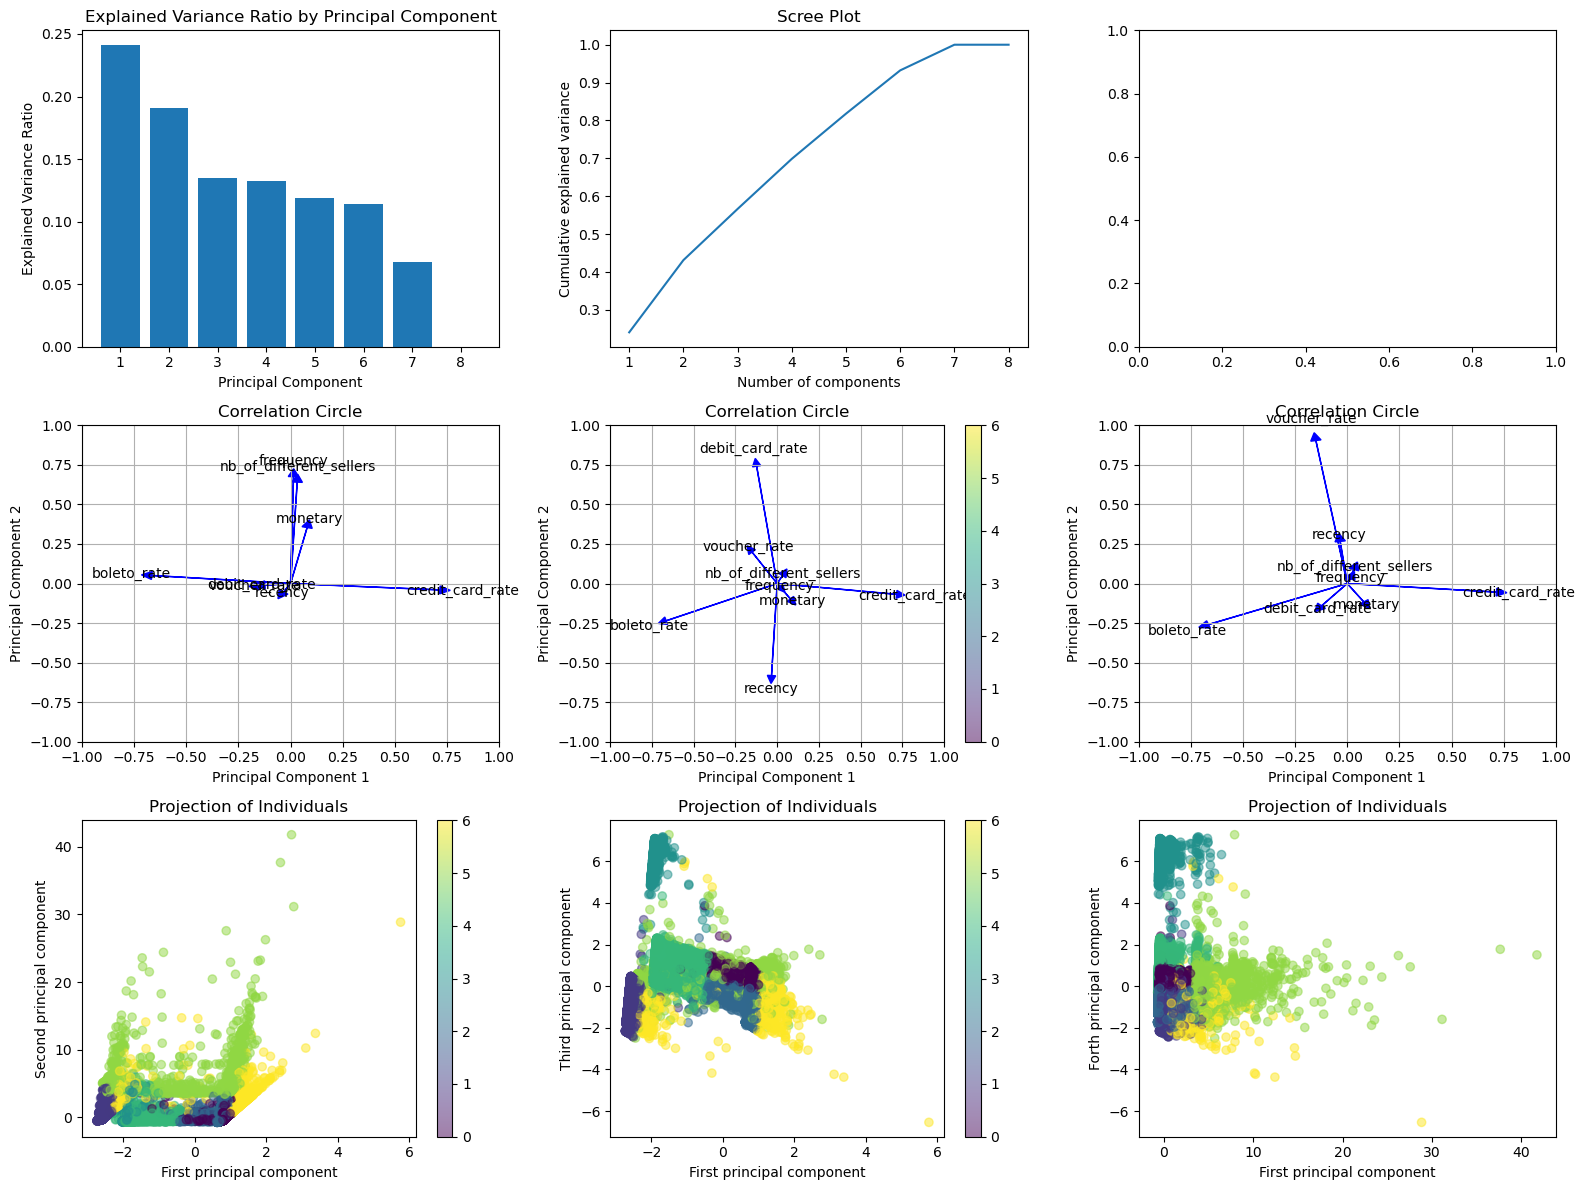

In [53]:
clusters, kmeans = kmeans_n(X_scaled)
plot_scaler(X, features, categories=None, rates=rates, c=clusters, X_scaled=X_scaled)
print("\n")

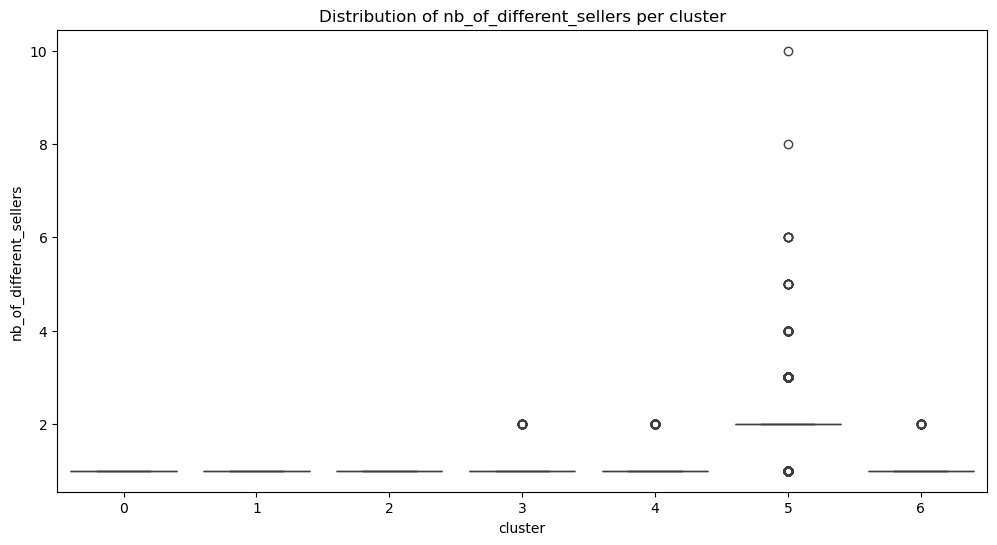

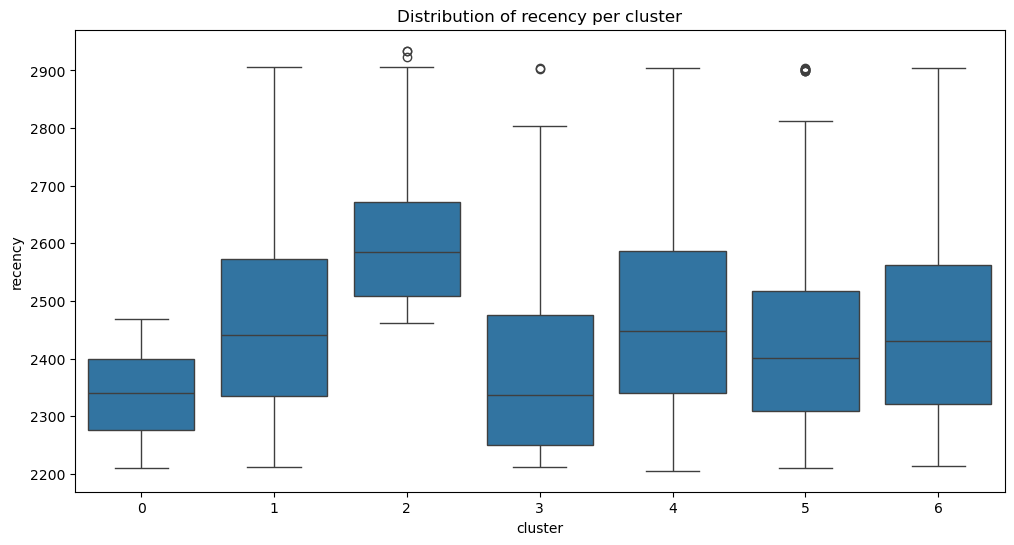

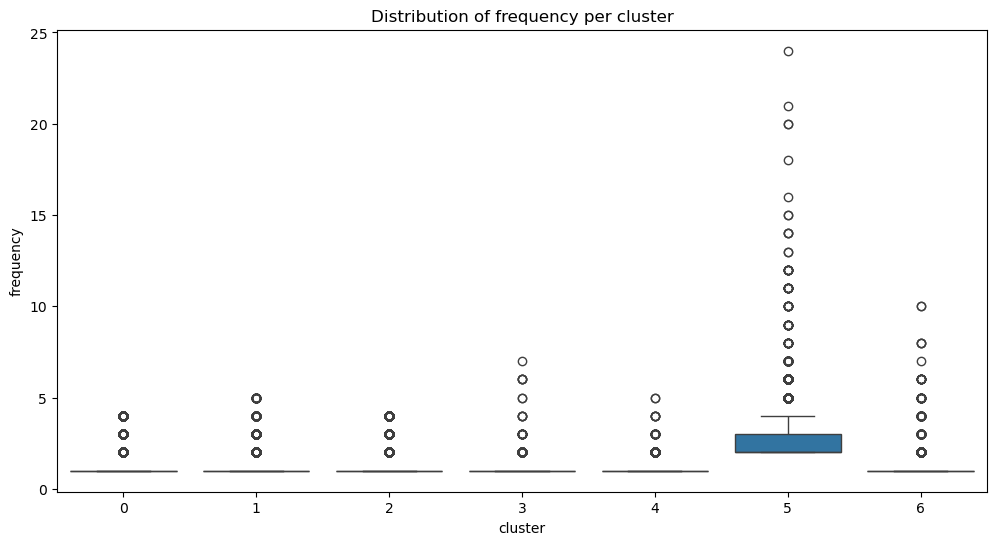

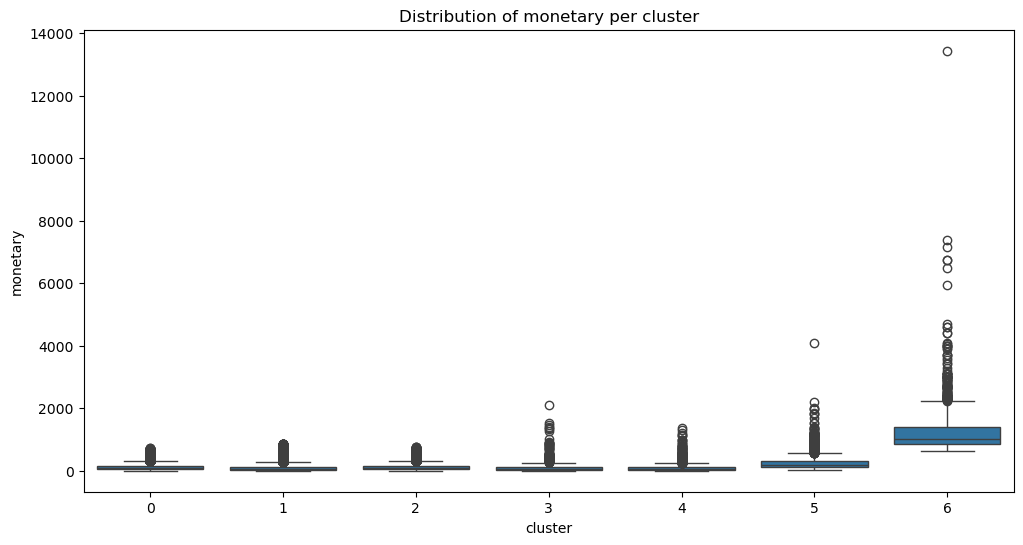

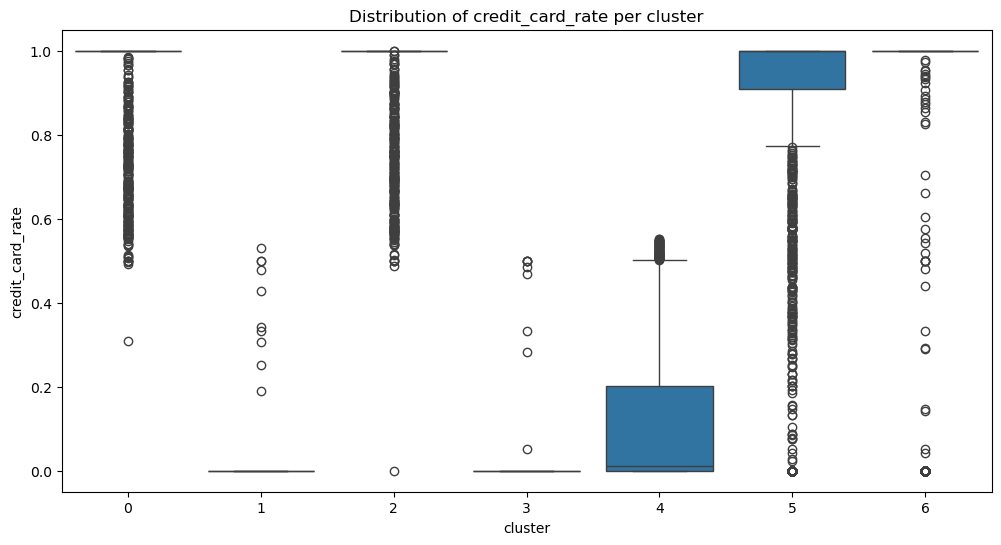

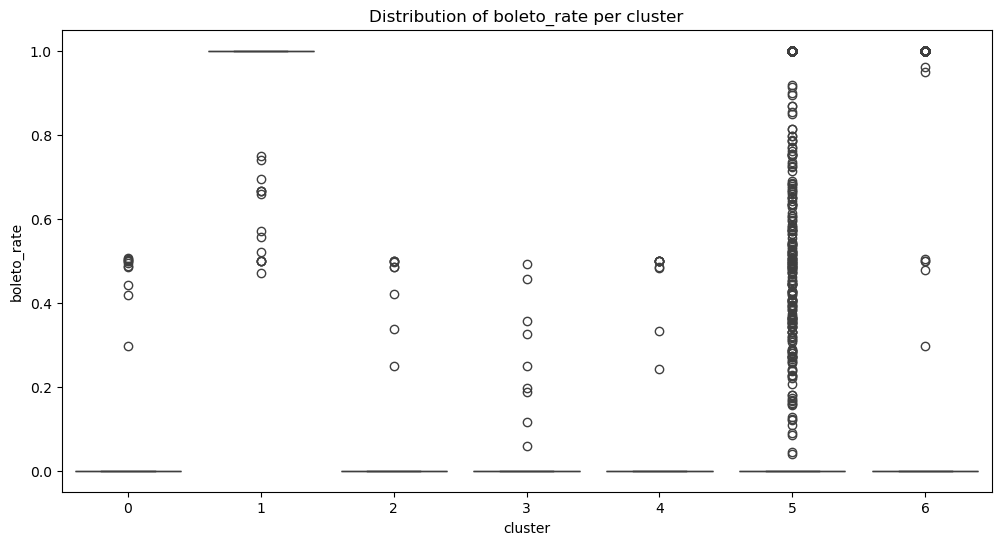

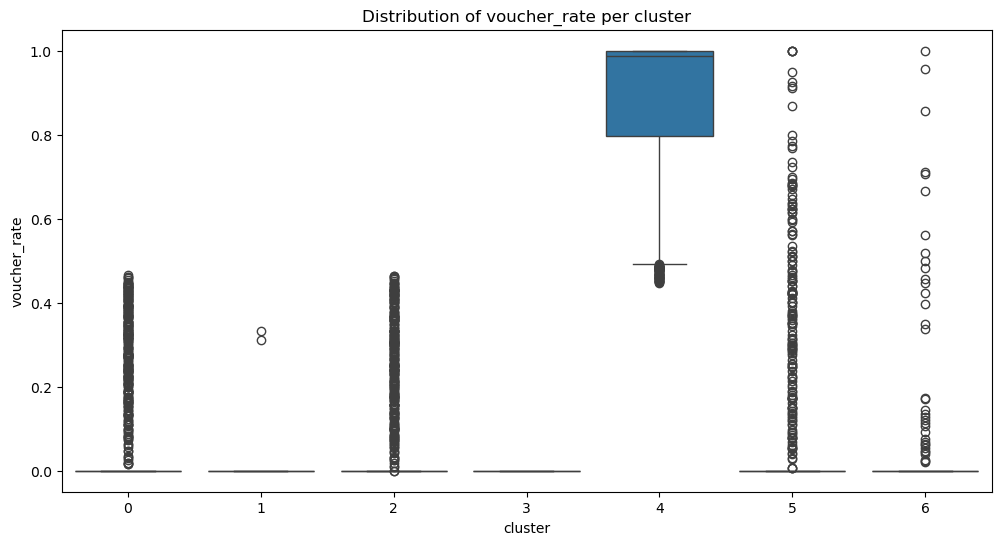

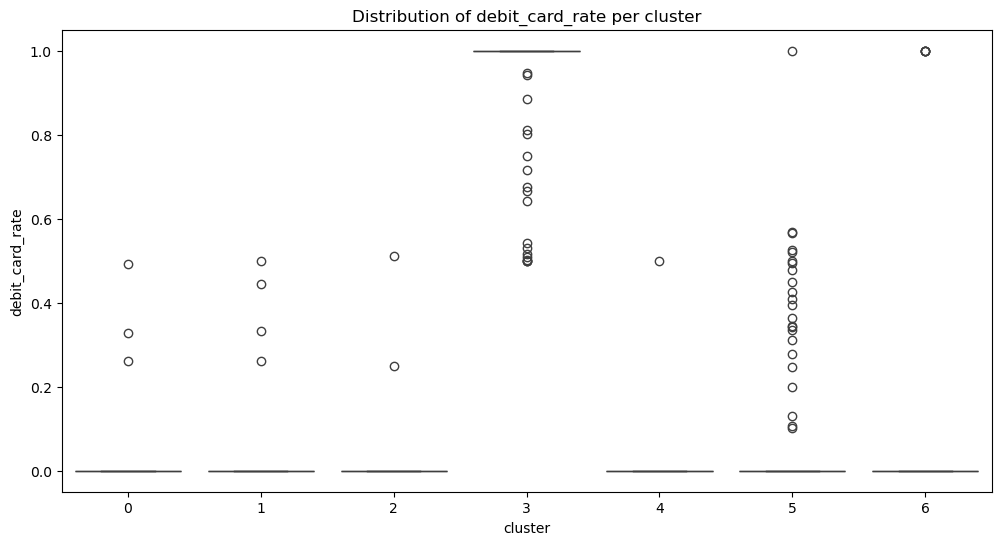

In [54]:
clusters = kmeans.predict(X_scaled)
plot_boxplots_per_cluster(X, clusters, features)

cluster size: 3 Silhouette score: 0.14
cluster size: 4 Silhouette score: 0.29
cluster size: 6 Silhouette score: 0.32
cluster size: 7 Silhouette score: 0.33
cluster size: 8 Silhouette score: 0.34
cluster size: 8 Silhouette score: 0.35
cluster size: 8 Silhouette score: 0.36
cluster size: 8 Silhouette score: 0.37
cluster size: 8 Silhouette score: 0.37
cluster size: 9 Silhouette score: 0.37
Columns: ['nb_of_different_sellers', 'recency', 'frequency', 'monetary']
Cumulative variance ratio for 2 components: 43.14%
component 3: 13.51%


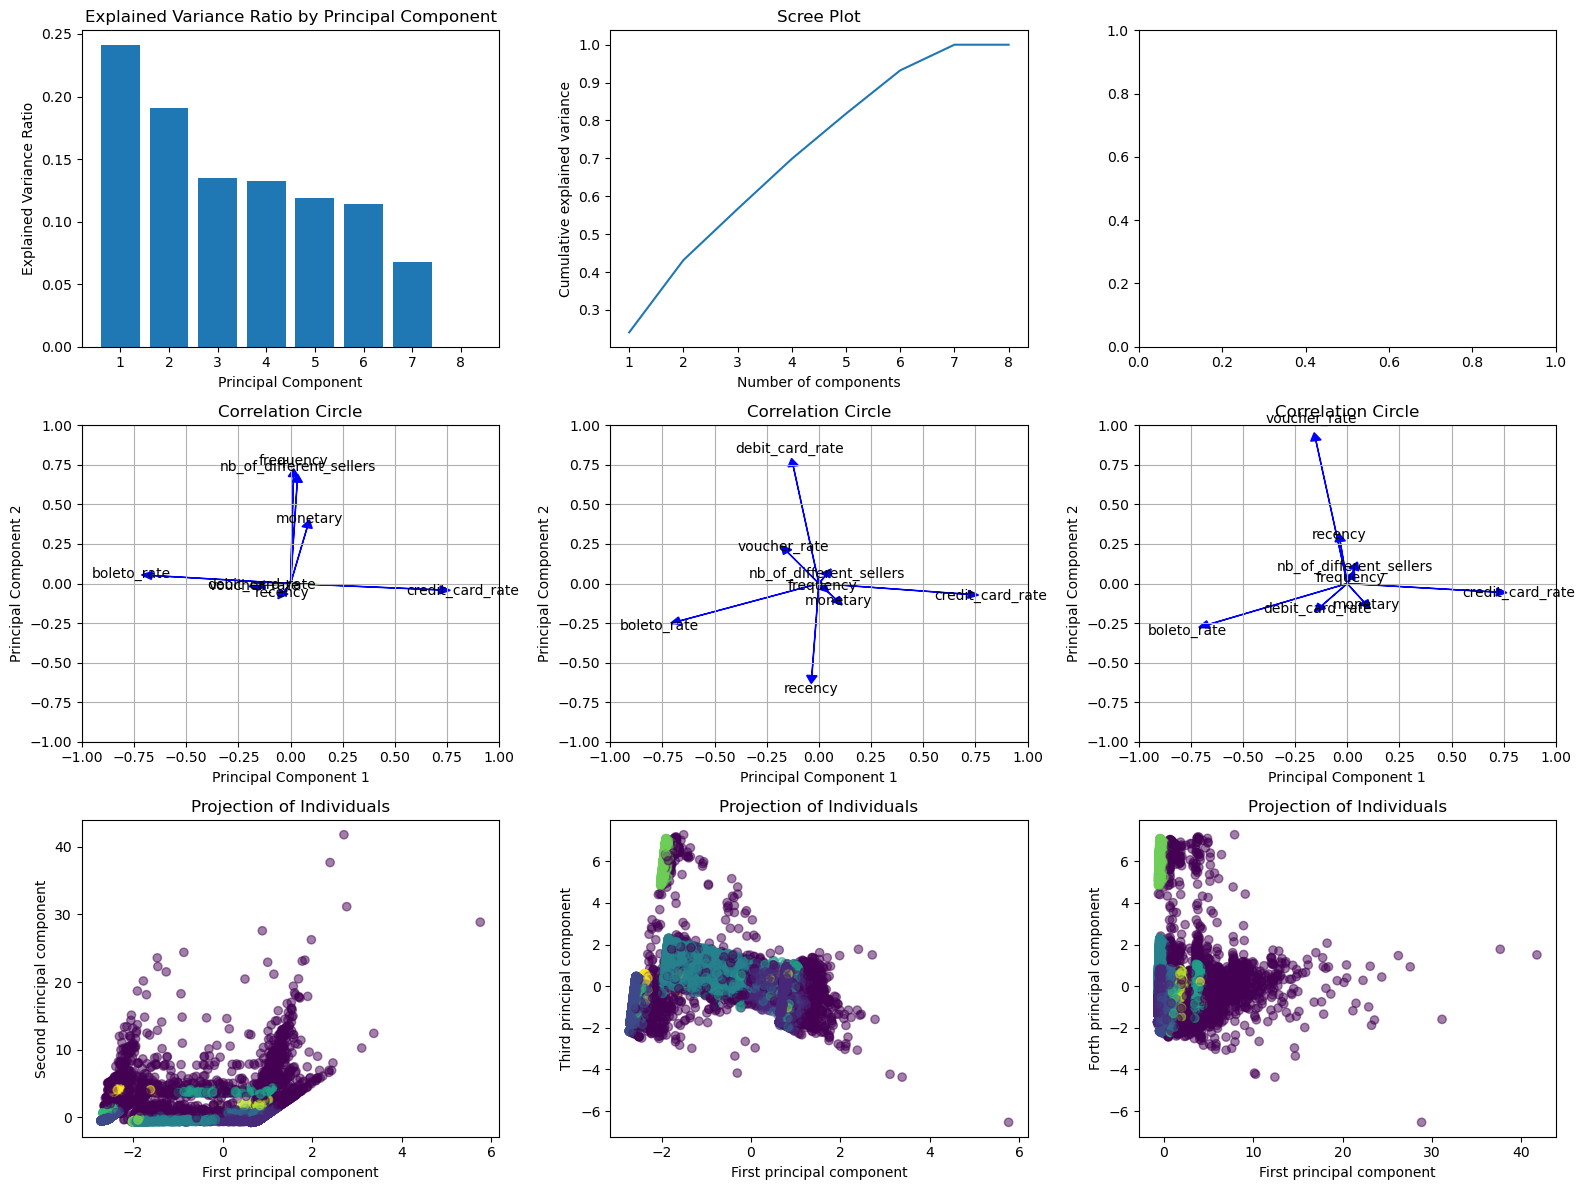

In [31]:
clusters, model = dbscan_n(X_scaled)
plot_scaler(X, features, categories=None, rates=rates, c=clusters, X_scaled=X_scaled)
print("\n")

(47710, 9)


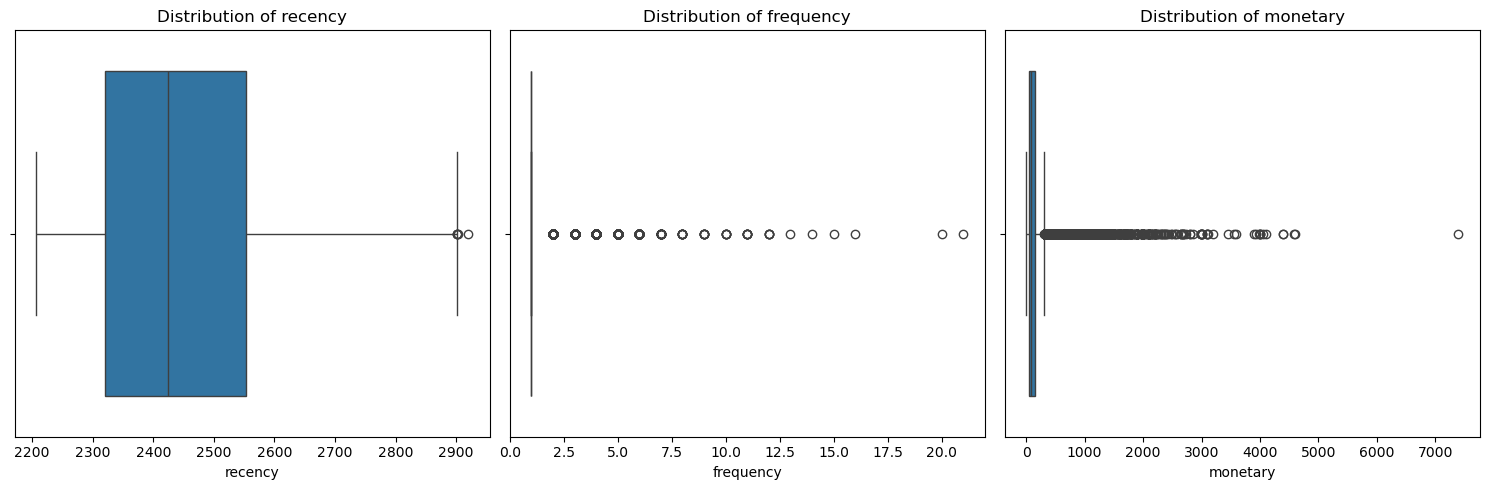

Nombre de clusters: [11587 34463  1660], Silhouette score: 0.50
Nombre de clusters: [10820 34463  1660   767], Silhouette score: 0.52
Nombre de clusters: [34463  9166  1660   767  1654], Silhouette score: 0.55
Nombre de clusters: [ 3505  9166  1660   767  1654 30958], Silhouette score: 0.57
Nombre de clusters: [ 1660  9166 30958   767  1654  3035   470], Silhouette score: 0.55
Nombre de clusters: [30958  9166   200  1460  1654  3035   470   767], Silhouette score: 0.56
Nombre de clusters: [23522  9166   200  1460  1654  3035   470   767  7436], Silhouette score: 0.46
Nombre de clusters: [ 9166 19952   200  1460  1654  3035   470   767  7436  3570], Silhouette score: 0.46
Nombre de clusters: [  200 19952  3035  1460  1654  8273   470   767  7436  3570   893], Silhouette score: 0.47
Nombre de clusters: [ 3035 19952  8273  1460  1654   185   470   767  7436  3570   893    15], Silhouette score: 0.47
Nombre de clusters: [ 8273 19952   470  1460  1654   185  2444   767  7436  3570   893    

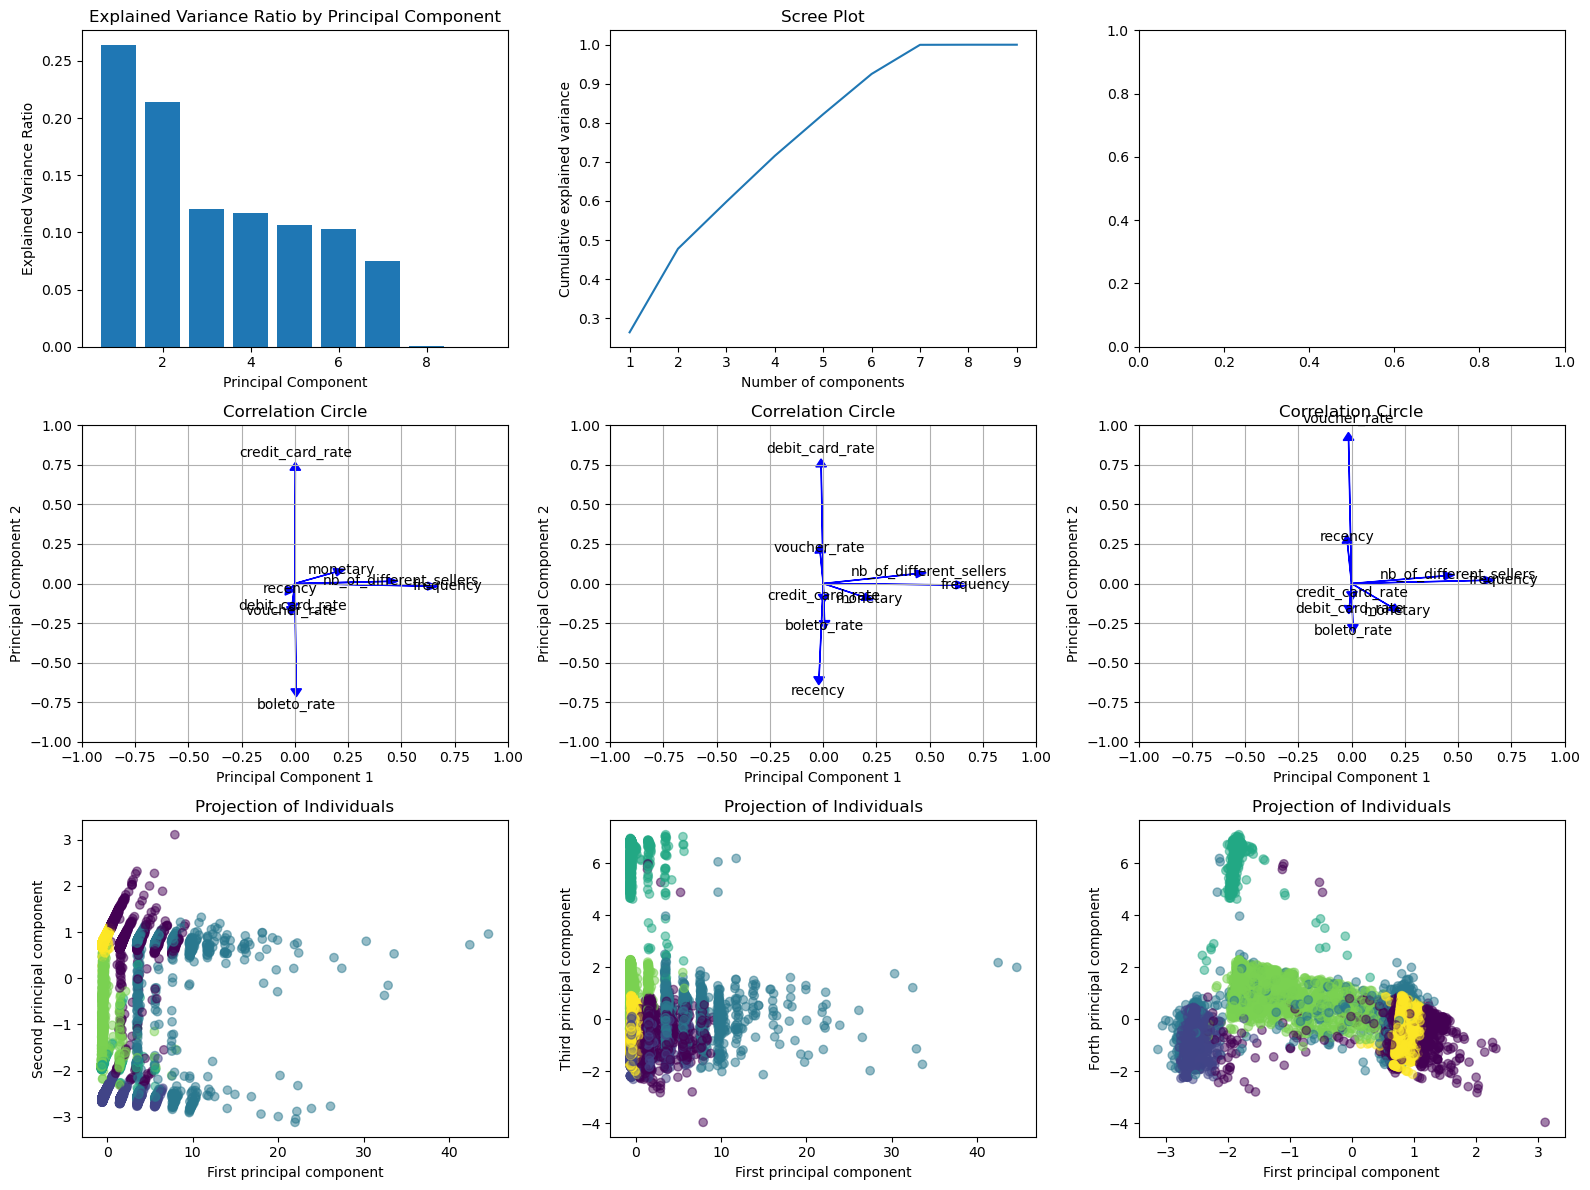

(array([[-0.16976115, -1.47743062, -0.29178621, ..., -0.18669165,
         -0.12812542, -0.29532395],
        [-0.16976115, -0.04503363, -0.29178621, ..., -0.18669165,
         -0.12812542, -0.29532395],
        [-0.16976115, -0.47377009, -0.29178621, ..., -0.18669165,
         -0.12812542, -0.29532395],
        ...,
        [-0.16976115,  0.28812797,  1.32600813, ..., -0.18669165,
         -0.12812542,  1.34513542],
        [-0.16976115,  0.50955592, -0.29178621, ..., -0.18669165,
         -0.12812542, -0.29532395],
        [-0.16976115, -0.80139892, -0.29178621, ..., -0.18669165,
         -0.12812542, -0.29532395]]),
 array([[-4.73765770e-01,  8.17803941e-01,  8.41769133e-01, ...,
         -1.26865903e-01, -2.44808143e-03, -1.54389401e-04],
        [-5.17663466e-01,  7.67486046e-01,  4.32857704e-03, ...,
         -1.24189471e-02, -2.03014603e-03, -2.83240920e-06],
        [-4.83960453e-01,  7.90379271e-01,  2.45866060e-01, ...,
         -3.95505120e-02, -2.18816404e-03, -5.01463565e-

In [40]:
X['frequency_gp'] = np.where(X['frequency'] < 14, X['frequency'], 14)
sampled_data, _ = train_test_split(X, test_size=0.5, stratify=X['frequency_gp'])
print(sampled_data.shape)
plot_boxplots(sampled_data, rfm)
sampled_data_scaled = StandardScaler().fit_transform(sampled_data)
clusters, model = agglomerative_clustering_n(sampled_data_scaled)
plot_scaler(sampled_data, features, categories=None, rates=rates, c=clusters, X_scaled=sampled_data_scaled)
print("\n")